## 10_Met_v0.1_results

This notebook contains the generation of the result section for the methodology developed as part of the LandGriffon platform. Link here: https://docs.google.com/document/d/1s1rINj-YVDQ36Vu-Q3T1sc55hcVLROJclaaELRF9tck/edit#

The idea would be to compute deforestation in three different location types using satelligence data. The location types to be enalysed are:

    - Point of production (selection of a palm oill mill)
    - Agrregation point (50km radius buffer arund that palm oil mill)
    - Administrative area (Aceh in our case)

NOTE: country of production cannot be performed as we are issing this coverege with Satelligence data. We can potentially cover this for a different indicator (e.g. water footprint)

    
Datasets needed:

    - palm oil mill locataions
    - deforetation datasets (satelligence)
    - gadm boundaries
    



In [181]:
# import libraries
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio as rio

#!pip install h3ronpy h3pandas --q
from h3ronpy import raster
import h3
import h3pandas
import pandas as pd
from shapely.geometry import Polygon

In [2]:
def buffer_stats(raster_path, vector_path, buffer=50000, stat_='sum', all_touched = True):
    """
    inputs:
    -------------
    raster_path: raster path for retriving the statisticts in EPSG:4326
    vector_path: path to point file in EPSG:4326
    buffer: distance in metres for coputing the buffer
    stats: stadistics to compute
    
    output
    -------
    array with statistics"""
    
    #open vector file
    gdf = gpd.read_file(vector_path)
    #check projection
    #if gdf.crs != True:
    #    print(gdf.crs)
    #    #project
    #    print('Dataset missing projection. Please assign one!')
    if gdf.crs and gdf.crs == 'EPSG:4326':
        #reproject
        gdf_3857 = gdf.to_crs('EPSG:3857')
    ## TODO:add other validations
    

    #get buffer
    gdf_3857_buffer = gdf_3857.buffer(buffer)
    #reproject back to epsg4326
    gdf_4326_buffer = gdf_3857_buffer.to_crs('EPSG:4326')
    #get statistics
    vizz_stats = []
    for geom in gdf_4326_buffer:
        stats = zonal_stats(geom,
                    raster_path,
                    stats=stat_,
                    all_touched = all_touched
            )
        stat_sum = stats[0]['sum']
        vizz_stats.append(stat_sum)
    #add stats in dataframe
    gdf['estimated']=vizz_stats
    return gdf

## Generate h3 dataset from raster

ingets data as density - This values would need to be multiplied by the hex area in the analysis:


 - 1. multiplies by 1 and remove no data values.
 - 2. downsample to the same resolution used for the otehr datasets ingested using the sum resampling method
 - 3. divides the sum by the total sum in each pixel to get the density
 - 4. Translate to h3
 - 5. Get pixel area ratio


In [7]:
!gdal_calc.py --calc "A*1" --format GTiff --type Float32 --NoDataValue 0.0 -A ../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01.tif --A_band 1 --outfile ../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01_mask.tif;
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -tr 0.0833333333333286 0.0833333333333286 -r sum  -multi -of GTiff ../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01_mask.tif ../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01_sum.tif
!gdal_calc.py --calc "A/1929012.345678793" --format GTiff --type Float32 --NoDataValue 0.0 -A ../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01_sum.tif --A_band 1 --outfile ../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01_density.tif

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 

48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 

71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 

94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 96.. 96.. 96.. 96.. 

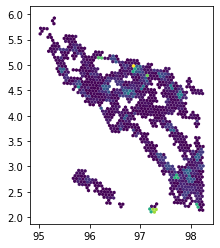

In [20]:
#translate density raster to h3
raster_path = '../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01_density.tif'
resolution = 6

with rio.open(raster_path) as src:
    gdf = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

    gdf.plot('value')
    gdf['h3index'] = gdf['h3index'].apply(hex)


,h3index,value,geometry
0,0x86650d2a7ffffff,85.911797,"POLYGON ((98.19943 3.26899, 98.20239 3.30521, ..."
1,0x86650d2afffffff,85.911797,"POLYGON ((98.13623 3.27382, 98.13919 3.31004, ..."
2,0x86650d2c7ffffff,85.911797,"POLYGON ((98.00981 3.28348, 98.01276 3.31971, ..."
3,0x86650d2cfffffff,85.911797,"POLYGON ((97.94660 3.28830, 97.94953 3.32453, ..."
4,0x86650d2efffffff,85.911797,"POLYGON ((97.97380 3.23156, 97.97674 3.26778, ..."


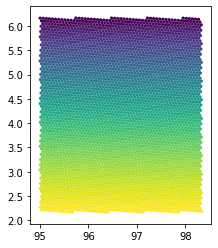

In [21]:
# translate pixel area to h3 to compute pixel area/h3 area ratio
#translate density raster to h3
raster_path = '../../datasets/processed/Satelligence_data/area_ratio/8_Areakm_clip_ind.tif'
resolution = 6

with rio.open(raster_path) as src:
    gdf_area = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

    gdf_area.plot('value')
    gdf_area['h3index'] = gdf_area['h3index'].apply(hex)

gdf_area.head()

In [22]:
merge_gdf = gdf.merge(gdf_area, on='h3index', how='left')
merge_gdf = merge_gdf.rename(columns={'value_x':'def_density','geometry_x':'geometry','value_y':'pixelAreaKm2'})
merge_gdf = merge_gdf[['h3index', 'def_density', 'pixelAreaKm2', 'geometry']]
merge_gdf.head()

,h3index,def_density,pixelAreaKm2,geometry
0,0x866556007ffffff,0.002240,85.750900,"POLYGON ((96.91803 4.79216, 96.92086 4.82860, ..."
1,0x866572717ffffff,0.003418,85.918999,"POLYGON ((97.39607 3.16612, 97.39895 3.20234, ..."
2,0x8665727a7ffffff,0.003418,85.918999,"POLYGON ((97.43201 3.21806, 97.43489 3.25429, ..."
3,0x8665727afffffff,0.003418,85.918999,"POLYGON ((97.36876 3.22285, 97.37164 3.25908, ..."
4,0x866573217ffffff,0.000811,85.964203,"POLYGON ((95.89182 2.62361, 95.89453 2.65976, ..."


In [29]:
merge_gdf['h3Area_km2'] = [h3.cell_area(h3index.split('x')[1]) for h3index in merge_gdf['h3index']]
merge_gdf['deforestation_km2'] = merge_gdf['def_density'] * merge_gdf['h3Area_km2']
merge_gdf['area_ratio'] = merge_gdf['h3Area_km2']/merge_gdf['pixelAreaKm2']
merge_gdf['def_km2_ratio'] = merge_gdf['deforestation_km2']*merge_gdf['area_ratio']
merge_gdf['h3index'] = [h3index.split('x')[1] for h3index in merge_gdf['h3index']]

merge_gdf.head()

,h3index,def_density,pixelAreaKm2,geometry,h3Area_km2,deforestation_km2,area_ratio,def_km2_ratio
0,866556007ffffff,0.002240,85.750900,"POLYGON ((96.91803 4.79216, 96.92086 4.82860, ...",43.068946,0.096490,0.502256,0.048463
1,866572717ffffff,0.003418,85.918999,"POLYGON ((97.39607 3.16612, 97.39895 3.20234, ...",42.673674,0.145841,0.496673,0.072435
2,8665727a7ffffff,0.003418,85.918999,"POLYGON ((97.43201 3.21806, 97.43489 3.25429, ...",42.685572,0.145881,0.496812,0.072476
3,8665727afffffff,0.003418,85.918999,"POLYGON ((97.36876 3.22285, 97.37164 3.25908, ...",42.689801,0.145896,0.496861,0.072490
4,866573217ffffff,0.000811,85.964203,"POLYGON ((95.89182 2.62361, 95.89453 2.65976, ...",42.552266,0.034513,0.495000,0.017084


In [15]:
#export to shp
merge_gdf = merge_gdf.set_geometry('geometry')
merge_gdf.to_file('../../datasets/raw/methodology_results/Deforestation_density_h3_res6.shp')


<ipython-input-15-569d5e5d2fec>:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merge_gdf.to_file('../../datasets/raw/methodology_results/Deforestation_density_h3_res6.shp')


,h3index,prod_t,geometry
0,866576727ffffff,415.500000,"POLYGON ((98.20974 2.23188, 98.21269 2.26794, ..."
1,866576737ffffff,415.500000,"POLYGON ((98.24567 2.28358, 98.24863 2.31964, ..."
2,866554d2fffffff,546.099976,"POLYGON ((97.13282 3.45945, 97.13567 3.49571, ..."
3,8665726d7ffffff,546.099976,"POLYGON ((97.16019 3.40267, 97.16305 3.43892, ..."
4,866550607ffffff,1390.099976,"POLYGON ((95.58240 4.89181, 95.58510 4.92827, ..."


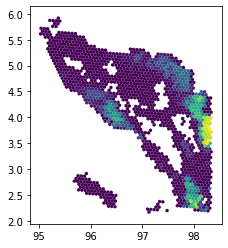

In [76]:
#convert palm oil production in Aceh to h3 format

raster_path = '../../datasets/raw/methodology_results/spam_palm_oil_prod_clip.tif'
resolution = 6

with rio.open(raster_path) as src:
    gdf_prod = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

    gdf_prod.plot('value')
    gdf_prod['h3index'] = gdf_prod['h3index'].apply(hex)

#gdf_prod.to_file('../../datasets/raw/methodology_results/palm_oil_prod_h3_res6_v2.shp')
gdf_prod = gdf_prod.rename(columns={'value':'prod_t'})
gdf_prod['h3index'] = [h3index.split('x')[1] for h3index in list(gdf_prod['h3index'])]
gdf_prod.head()

,h3index,ha,geometry
0,86655285fffffff,56.799999,"POLYGON ((96.08837 5.23947, 96.09112 5.27597, ..."
1,866552b1fffffff,56.799999,"POLYGON ((95.92505 5.19656, 95.92779 5.23305, ..."
2,866552bb7ffffff,56.799999,"POLYGON ((96.06065 5.29658, 96.06340 5.33308, ..."
3,866509787ffffff,375.100006,"POLYGON ((97.71779 4.40163, 97.72071 4.43801, ..."
4,866509797ffffff,375.100006,"POLYGON ((97.75390 4.45377, 97.75683 4.49016, ..."


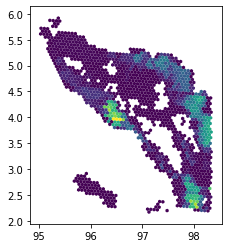

In [77]:
#convert palm oil production in Aceh to h3 format

raster_path = '../../datasets/raw/methodology_results/spam_palm_oil_ha_clip.tif'
resolution = 6

with rio.open(raster_path) as src:
    gdf_ha = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

    gdf_ha.plot('value')
    gdf_ha['h3index'] = gdf_ha['h3index'].apply(hex)

#gdf_ha.to_file('../../datasets/raw/methodology_results/palm_oil_ha_h3_res6.shp')
gdf_ha = gdf_ha.rename(columns={'value':'ha'})
gdf_ha['h3index'] = [h3index.split('x')[1] for h3index in list(gdf_ha['h3index'])]
gdf_ha.head()

In [101]:
def_gdf = gdf_prod.merge(merge_gdf, on='h3index', how='left').merge(gdf_ha, on='h3index', how='left')
def_gdf =  def_gdf[['h3index', 'prod_t', 'def_density', 'pixelAreaKm2', 'h3Area_km2', 'deforestation_km2', 'area_ratio', 'def_km2_ratio', 'ha', 'geometry']]
def_gdf.head()

,h3index,prod_t,def_density,pixelAreaKm2,h3Area_km2,deforestation_km2,area_ratio,def_km2_ratio,ha,geometry
0,866576727ffffff,415.500000,0.000155,85.986000,42.360676,0.006566,0.492646,0.003235,34.200001,"POLYGON ((98.20974 2.23188, 98.21269 2.26794, ..."
1,866576737ffffff,415.500000,0.000115,85.986000,42.373203,0.004877,0.492792,0.002403,34.200001,"POLYGON ((98.24567 2.28358, 98.24863 2.31964, ..."
2,866554d2fffffff,546.099976,0.000814,85.896896,42.760220,0.034802,0.497809,0.017325,493.000000,"POLYGON ((97.13282 3.45945, 97.13567 3.49571, ..."
3,8665726d7ffffff,546.099976,0.000194,85.896896,42.744834,0.008310,0.497630,0.004135,493.000000,"POLYGON ((97.16019 3.40267, 97.16305 3.43892, ..."
4,866550607ffffff,1390.099976,0.000745,85.740196,43.092321,0.032124,0.502592,0.016145,355.000000,"POLYGON ((95.58240 4.89181, 95.58510 4.92827, ..."


## Sanity check:

Check deforestation computed by satelligence in the different mill versus the one that we obtained using the h3 data ingestion:

In [30]:
# get deforestation in buffer zones

vector_path = '../../datasets/processed/Satelligence_data/test_rasters_2/satelligence_mills_4326_50kmbuffer.shp'
resolution = 6

gdf_vector = gpd.read_file(vector_path)
clean_gdf = gdf_vector[['gfw_fid','deforestat','geometry']]

_sum_calculated = []
for i, row in clean_gdf.iterrows():
    filtered_gdf = clean_gdf[i:i+1]
    #convert to h3
    h3_gdf = filtered_gdf.h3.polyfill_resample(resolution)
    h3index_list = [f'0x{h3index}' for h3index in h3_gdf.index]
    _sum = merge_gdf[merge_gdf['h3index'].isin(h3index_list)]['deforestation_km2'].sum()*100
    _sum_calculated.append(_sum)
    
#_sum_calculated

In [14]:
#zonal statistics raster
stats_ = buffer_stats('../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01.tif',
                      '../../datasets/processed/palm_oil_mills/satelligence_mills_4326_point.shp',
                      buffer=50000,
                      stat_='sum', all_touched = False)

In [21]:
def_raster = list(stats_['estimated']*6.69019042035408517*6.69019042035408517* 0.0001)

### 1. Point of production:

    -Example mill name: AGRA BUMI NIAGA
    -Gfw_id = 1873
    -Uml_id = PO1000010250
    -Lat, lon = 4.575718, 97.6190685
    -Country = Indonesia

#### Land impact:

land impact(ha) = volume(T) * sum(Harvest area (ha)) /sum( production (T))


forest loss (ha) = deforestation (ha/yr) * land impact (ha) /sum(harvest area) (ha)



In [99]:
point_location = gpd.read_file('../../datasets/raw/methodology_results/test_location_point.geojson')
point_location = point_location.h3.geo_to_h3(6).reset_index(drop=False)

point_location = point_location[['h3_06']]

point_location['geometry'] = Polygon(h3.h3_to_geo_boundary(point_location['h3_06'][0], geo_json=True))
point_location = point_location.set_geometry('geometry')
point_location.to_file('../../datasets/raw/methodology_results/test_location_point_h3_res6_v3.shp')

point_location


,h3_06,geometry
0,866509697ffffff,"POLYGON ((97.63571 4.57267, 97.63863 4.60908, ..."


In [102]:
#obtain deforestation that takes places in that hexagon

h3index_list = list(point_location['h3_06'])

def_point_loc = def_gdf[def_gdf['h3index'].isin(h3index_list)]
def_point_loc


,h3index,prod_t,def_density,pixelAreaKm2,h3Area_km2,deforestation_km2,area_ratio,def_km2_ratio,ha,geometry
381,866509697ffffff,14998.599609,0.006317,85.771797,42.993477,0.271599,0.501254,0.13614,947.200012,"POLYGON ((97.63571 4.57267, 97.63863 4.60908, ..."


In [107]:
#asumming volume equal to 1T
land_impact_point = 1*def_point_loc['ha'].sum()/def_point_loc['prod_t'].sum()
print(f'land impact: {land_impact_point} ha')

def_impact = ((def_point_loc['deforestation_km2'].sum()*100) * land_impact_point) / def_point_loc['ha'].sum()
print(f'Forest loss risk:{def_impact} ha')

land impact: 0.06315256336431409 ha
Forest loss risk:0.0018108314565203176 ha


### 2. Aggergation point - 50km buffer:

    -Example mill name: AGRA BUMI NIAGA
    -Gfw_id = 1873
    -Uml_id = PO1000010250
    -Lat, lon = 4.575718, 97.6190685
    -Country = Indonesia

land impact(ha) = volume(T) * sum(Harvest area (ha)) /sum( production (T))

forest loss (ha) = deforestation (ha/yr) * land impact (ha) /sum(harvest area) (ha)

In [135]:
agg_point = gpd.read_file('../../datasets/raw/methodology_results/test_location_point.geojson')
agg_point = agg_point.to_crs('EPSG:3857')
agg_point = agg_point_3857.buffer(50000)
agg_point = agg_point_buffer.to_crs('EPSG:4326')

h3_agg_point = h3.polyfill(agg_point.geometry[0].__geo_interface__, 6, geo_json_conformant = True)

agg_point_gdf = gpd.GeoDataFrame(h3_agg_point)
agg_point_gdf =  agg_point_gdf.rename(columns={0:'h3index'})
agg_point_gdf['geometry'] = [Polygon(h3.h3_to_geo_boundary(h3index,  geo_json=True)) for h3index in list(agg_point_gdf['h3index'])]
agg_point_gdf.to_file('../../datasets/raw/methodology_results/test_agg_point_h3_res6_v2.shp')
agg_point_gdf.head()

,h3index,geometry
0,86650948fffffff,"POLYGON ((97.98040 4.49128, 97.98335 4.52766, ..."
1,86650970fffffff,"POLYGON ((97.60951 4.24525, 97.61242 4.28161, ..."
2,866509697ffffff,"POLYGON ((97.63571 4.57267, 97.63863 4.60908, ..."
3,866509667ffffff,"POLYGON ((97.41920 4.25976, 97.42209 4.29613, ..."
4,866556d1fffffff,"POLYGON ((97.45391 4.69647, 97.45680 4.73289, ..."


In [138]:
h3index_list = list(agg_point_gdf['h3index'])

def_agg_loc = def_gdf[def_gdf['h3index'].isin(h3index_list)]
def_agg_loc.head()

,h3index,prod_t,def_density,pixelAreaKm2,h3Area_km2,deforestation_km2,area_ratio,def_km2_ratio,ha,geometry
7,86650b34fffffff,19665.000000,NaN,NaN,NaN,NaN,NaN,NaN,1188.599976,"POLYGON ((97.50743 4.96729, 97.51034 5.00374, ..."
8,866556cb7ffffff,19665.000000,NaN,NaN,NaN,NaN,NaN,NaN,1188.599976,"POLYGON ((97.47129 4.91505, 97.47419 4.95150, ..."
53,86650bae7ffffff,16836.500000,NaN,NaN,NaN,NaN,NaN,NaN,999.099976,"POLYGON ((97.71674 4.78627, 97.71967 4.82270, ..."
73,86650961fffffff,106.599998,0.000019,85.791801,42.966153,0.000824,0.500819,0.000413,31.799999,"POLYGON ((97.52741 4.41619, 97.53031 4.45258, ..."
74,8665096e7ffffff,106.599998,0.000019,85.791801,42.970428,0.000824,0.500869,0.000413,31.799999,"POLYGON ((97.46394 4.42103, 97.46684 4.45742, ..."


In [139]:
#asumming volume equal to 1T
land_impact_agg_point = 1*def_agg_loc['ha'].sum()/def_agg_loc['prod_t'].sum()
print(f'land impact: {land_impact_agg_point} ha')

def_impact_agg = ((def_agg_loc['deforestation_km2'].sum()*100) * land_impact_agg_point) / def_agg_loc['ha'].sum()
print(f'Forest loss risk:{def_impact_agg} ha')

land impact: 0.07172119293987887 ha
Forest loss risk:0.00040548268980856805 ha


### 3. Admin area - Aceh:

land impact (ha) = volume(T) * sum(Harvest area (ha)) /sum( production (T))

forest loss (ha) = deforestation (ha/yr) * land impact (ha) /sum(harvest area) (ha)

In [203]:
adm_loc = gpd.read_file('../../datasets/raw/methodology_results/aceh_loc.geojson')
adm_loc = adm_loc.explode(index_parts=True)
h3_multipol = [h3.polyfill(geom.__geo_interface__, 6, geo_json_conformant = True) for geom in list(adm_loc['geometry'])]

for i in range(0,len(h3_multipol)):
    if i == 0:
        df_mult = pd.DataFrame(h3_multipol[i])
    else:
        
        df_ = pd.DataFrame(h3_multipol[i])
        df_mult = pd.concat([df_mult, df_])
df_mult =  df_mult.rename(columns={0:'h3index'})
df_mult['geometry'] = [Polygon(h3.h3_to_geo_boundary(h3index,  geo_json=True)) for h3index in list(df_mult['h3index'])]
df_mult = df_mult.set_geometry('geometry')
df_mult.to_file('../../datasets/raw/methodology_results/test_aceh_h3_res6.shp')
df_mult.head()

,h3index,geometry
0,866573917ffffff,"POLYGON ((96.64380 2.07756, 96.64658 2.11362, ..."
1,86657064fffffff,"POLYGON ((96.70686 2.07286, 96.70965 2.10891, ..."
0,86657044fffffff,"POLYGON ((97.14820 2.03986, 97.15104 2.07590, ..."
0,8665739a7ffffff,"POLYGON ((96.67951 2.12930, 96.68230 2.16536, ..."
0,8665704cfffffff,"POLYGON ((97.19252 2.19974, 97.19536 2.23581, ..."


In [204]:
h3index_list = list(df_mult['h3index'])

def_aceh = def_gdf[def_gdf['h3index'].isin(h3index_list)]
def_aceh.head()

,h3index,prod_t,def_density,pixelAreaKm2,h3Area_km2,deforestation_km2,area_ratio,def_km2_ratio,ha,geometry
2,866554d2fffffff,546.099976,0.000814,85.896896,42.760220,0.034802,0.497809,0.017325,493.0,"POLYGON ((97.13282 3.45945, 97.13567 3.49571, ..."
3,8665726d7ffffff,546.099976,0.000194,85.896896,42.744834,0.008310,0.497630,0.004135,493.0,"POLYGON ((97.16019 3.40267, 97.16305 3.43892, ..."
4,866550607ffffff,1390.099976,0.000745,85.740196,43.092321,0.032124,0.502592,0.016145,355.0,"POLYGON ((95.58240 4.89181, 95.58510 4.92827, ..."
5,866550627ffffff,1390.099976,0.000745,85.740196,43.081664,0.032116,0.502468,0.016137,355.0,"POLYGON ((95.61017 4.83479, 95.61286 4.87124, ..."
6,86655062fffffff,1390.099976,0.000745,85.740196,43.081108,0.032115,0.502461,0.016137,355.0,"POLYGON ((95.54656 4.83947, 95.54925 4.87592, ..."


In [205]:
#asumming volume equal to 1T
land_impact_aceh = 1*def_aceh['ha'].sum()/def_aceh['prod_t'].sum()
print(f'land impact: {land_impact_aceh} ha')

def_impact_aceh = ((def_aceh['deforestation_km2'].sum()*100) * land_impact_aceh) / def_aceh['ha'].sum()
print(f'Forest loss risk:{def_impact_aceh} ha')

land impact: 0.08719526312344092 ha
Forest loss risk:0.0007569704003947574 ha
